# Notebook dependencies

In [1]:
import pandas as pd
import numpy as np

import networkx as nx
from sklearn import preprocessing
from scipy.stats import spearmanr

import itertools
from hashlib import md5
import pycountry_convert

import matplotlib.pyplot as plt
import plotly
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.io as pio
init_notebook_mode(connected=True)


# Setting pandas options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

Let's also create a couple of utility functions

In [2]:
def country_to_countrycode(country):
    if pd.isna(country):
        return np.nan
    else:
        try:
            return pycountry_convert.country_name_to_country_alpha2(country)
        except:
            return np.nan
        
def countrycode_to_continent(country_code):
    if pd.isna(country_code):
        return np.nan
    else:
        try:
            return pycountry_convert.country_alpha2_to_continent_code(country_code)
        except:
            return np.nan

# Data preparation

Load raw datasets for further analysis

In [3]:
ijhcs = pd.read_json('./data/raw/ijhcs_metadata/ijhcs.txt', lines=True)
ijhcs_ref = pd.read_json('./data/raw/ijhcs_metadata/ijhcs_ref.txt', lines=True)
ijhcs_cite = pd.read_json('./data/raw/ijhcs_metadata/ijhcs_cite.txt', lines=True)

Filter the papers without DOI and related referenced/citing ones

In [4]:
ijhcs = ijhcs.loc[(ijhcs.doi != '') & (ijhcs.year != 2019)]
ijhcs_ref = ijhcs_ref.loc[ijhcs_ref.citingid.isin(ijhcs.paperid)]
ijhcs_cite = ijhcs_cite.loc[ijhcs_cite.citedid.isin(ijhcs.paperid)]

In [5]:
to_remove = ijhcs[(~ijhcs.doi.str.contains('ijhcs')) & (~ijhcs.doi.str.contains('ijhsc')) & (ijhcs.year >= 2004)].doi
ijhcs = ijhcs[~ijhcs.doi.isin(to_remove)]

Let's now resolve evey single contribution for each paper. (This will take some time...)

In [6]:
ijhcs_contributions = ijhcs[['paperid', 'authors', 'year']]
ijhcs_contributions.head()

,paperid,authors,year
0,233418418,"[{'order': 2, 'authorid': 2065067515, 'name': 'oswald d kothgassner', 'gridid': 'grid.10420.37', 'affiliation': 'University of Vienna', 'country': 'Austria'}, {'order': 7, 'authorid': 1964867428, 'name': 'ilse kryspinexner', 'gridid': 'grid.10420.37', 'affiliation': 'University of Vienna', 'country': 'Austria'}, {'order': 4, 'authorid': 2443860983, 'name': 'annakatharina heinzle', 'gridid': 'grid.10420.37', 'affiliation': 'University of Vienna', 'country': 'Austria'}, {'order': 3, 'authorid'...",2015
3,1968303404,"[{'order': 4, 'authorid': 2118717156, 'name': 'paloma diaz', 'gridid': 'grid.7840.b', 'affiliation': 'Carlos III University of Madrid', 'country': 'Spain'}, {'order': 3, 'authorid': 318454244, 'name': 'rosa romerogomez', 'gridid': 'grid.7840.b', 'affiliation': 'Carlos III University of Madrid', 'country': 'Spain'}, {'order': 1, 'authorid': 2127899845, 'name': 'david diez', 'gridid': 'grid.7840.b', 'affiliation': 'Carlos III University of Madrid', 'country': 'Spain'}, {'order': 5, 'authorid':...",2014
4,1973659820,"[{'order': 1, 'authorid': 2719563323, 'name': 'h t smith'}]",1980
5,1983820888,"[{'order': 1, 'authorid': 11409961, 'name': 'james p delgrande', 'gridid': 'grid.61971.38', 'affiliation': 'Simon Fraser University', 'country': 'Canada'}]",1987
6,1988871241,"[{'order': 1, 'authorid': 2710249256, 'name': 'e j calvert'}, {'order': 2, 'authorid': 2710343780, 'name': 'r c waterfall', 'gridid': 'grid.5379.8', 'affiliation': 'University of Manchester', 'country': 'United Kingdom'}]",1982


In [7]:
ijhcs_contributions = ijhcs_contributions.join(ijhcs_contributions.authors.apply(pd.Series)) \
                                         .drop(columns='authors') \
                                         .melt(id_vars=['paperid', 'year'], value_name="author") \
                                         .drop(columns='variable') \
                                         .dropna() \
                                         .sort_values(by='paperid')
ijhcs_contributions.head()

,paperid,year,author
824,19554764,2013,"{'order': 1, 'authorid': 2106913481, 'name': 'enrico motta', 'gridid': 'grid.10837.3d', 'affiliation': 'The Open University', 'country': 'United Kingdom'}"
3065,21239000,1974,"{'order': 1, 'authorid': 2703520782, 'name': 'i j blain'}"
2388,22089359,1977,"{'order': 1, 'authorid': 2617385127, 'name': 'patrick j hayes'}"
2628,23658394,1988,"{'order': 1, 'authorid': 2423938681, 'name': 'm m taylor'}"
6907,29221325,1994,"{'order': 1, 'authorid': 2695880810, 'name': 'e hollnagel'}"


In [8]:
ijhcs_contributions = ijhcs_contributions.join(ijhcs_contributions.author.apply(pd.Series)) \
                                         .drop(columns='author') \
                                         .sort_values(by='paperid')
#                                         .dropna()
ijhcs_contributions['countrycode'] = ijhcs_contributions.country.map(country_to_countrycode)
ijhcs_contributions.head()

,paperid,year,order,authorid,name,gridid,affiliation,country,countrycode
824,19554764,2013,1,2106913481,enrico motta,grid.10837.3d,The Open University,United Kingdom,GB
3065,21239000,1974,1,2703520782,i j blain,NaN,NaN,NaN,NaN
2388,22089359,1977,1,2617385127,patrick j hayes,NaN,NaN,NaN,NaN
2628,23658394,1988,1,2423938681,m m taylor,NaN,NaN,NaN,NaN
6907,29221325,1994,1,2695880810,e hollnagel,NaN,NaN,NaN,NaN


Load external datasets for affiliation analysis (grid IDs and country centroids)

In [9]:
grid_df = pd.read_csv('./data/external/grid.csv')
grid_df.Country.replace({'State of Palestine': 'Palestine',
                         'Reunion': 'Réunion',
                         'Aland Islands': 'Åland Islands',
                         'Curacao': 'Curaçao'}, inplace=True)
grid_df['Countrycode'] = grid_df['Country'].map(lambda country: country_to_countrycode(country))
grid_df.head()

,ID,Name,City,State,Country,Countrycode
0,grid.1001.0,Australian National University,Canberra,Australian Capital Territory,Australia,AU
1,grid.1002.3,Monash University,Melbourne,Victoria,Australia,AU
2,grid.1003.2,University of Queensland,Brisbane,Queensland,Australia,AU
3,grid.1004.5,Macquarie University,Sydney,New South Wales,Australia,AU
4,grid.1005.4,UNSW Australia,Sydney,New South Wales,Australia,AU


In [10]:
centroids = pd.read_csv('./data/external/country_centroids_az8.csv')
additional_centroids = pd.DataFrame(data=[['GP', 29.030833, -118.28],
                                          ['RE', -21.114444, 55.5325],
                                          ['BQ', 12.183333, -68.25],
                                          ['MQ', 4.666667, -61.0],
                                          ['TV', -8.520833, 179.198611],
                                          ['NA', -22.0, 17.0],
                                          ['GF', 4.0, -53.0],
                                          ['XK', 42.583333, 21.0]],
                           columns=['iso_a2', 'Latitude', 'Longitude'])
centroids = centroids.append(additional_centroids, sort=False)
centroids.head()

,FID,the_geom,FID_,scalerank,featurecla,labelrank,sovereignt,sov_a3,adm0_dif,level,type,admin,adm0_a3,geou_dif,geounit,gu_a3,su_dif,subunit,su_a3,brk_diff,name,name_long,brk_a3,brk_name,brk_group,abbrev,postal,formal_en,formal_fr,note_adm0,note_brk,name_sort,name_alt,mapcolor7,mapcolor8,mapcolor9,mapcolor13,pop_est,gdp_md_est,pop_year,lastcensus,gdp_year,economy,income_grp,wikipedia,fips_10,iso_a2,iso_a3,iso_n3,un_a3,wb_a2,wb_a3,woe_id,adm0_a3_is,adm0_a3_us,adm0_a3_un,adm0_a3_wb,continent,region_un,subregion,region_wb,name_len,long_len,abbrev_len,tiny,homepart,Longitude,Latitude
0,country_centroids_az8.1,POINT (-69.9826771125 12.5208803838),0.0,3.0,Admin-0 country,5.0,Netherlands,NL1,1.0,2.0,Country,Aruba,ABW,0.0,Aruba,ABW,0.0,Aruba,ABW,0.0,Aruba,Aruba,ABW,Aruba,NaN,Aruba,AW,Aruba,NaN,Neth.,NaN,Aruba,NaN,4.0,2.0,2.0,9.0,103065.0,2258.0,-99.0,2010.0,-99.0,6. Developing region,2. High income: nonOECD,-99.0,NaN,AW,ABW,533.0,533.0,AW,ABW,-99.0,ABW,ABW,-99.0,-99.0,North America,Americas,Caribbean,Latin America & Caribbean,5.0,5.0,5.0,4.0,-99.0,-69.982677,12.520880
1,country_centroids_az8.2,POINT (66.0047336558 33.8352307278),1.0,1.0,Admin-0 country,3.0,Afghanistan,AFG,0.0,2.0,Sovereign country,Afghanistan,AFG,0.0,Afghanistan,AFG,0.0,Afghanistan,AFG,0.0,Afghanistan,Afghanistan,AFG,Afghanistan,NaN,Afg.,AF,Islamic State of Afghanistan,NaN,NaN,NaN,Afghanistan,NaN,5.0,6.0,8.0,7.0,28400000.0,22270.0,-99.0,1979.0,-99.0,7. Least developed region,5. Low income,-99.0,NaN,AF,AFG,4.0,4.0,AF,AFG,-99.0,AFG,AFG,-99.0,-99.0,Asia,Asia,Southern Asia,South Asia,11.0,11.0,4.0,-99.0,1.0,66.004734,33.835231
2,country_centroids_az8.3,POINT (17.5373676815 -12.2933605438),2.0,1.0,Admin-0 country,3.0,Angola,AGO,0.0,2.0,Sovereign country,Angola,AGO,0.0,Angola,AGO,0.0,Angola,AGO,0.0,Angola,Angola,AGO,Angola,NaN,Ang.,AO,People's Republic of Angola,NaN,NaN,NaN,Angola,NaN,3.0,2.0,6.0,1.0,12799293.0,110300.0,-99.0,1970.0,-99.0,7. Least developed region,3. Upper middle income,-99.0,NaN,AO,AGO,24.0,24.0,AO,AGO,-99.0,AGO,AGO,-99.0,-99.0,Africa,Africa,Middle Africa,Sub-Saharan Africa,6.0,6.0,4.0,-99.0,1.0,17.537368,-12.293361
3,country_centroids_az8.4,POINT (-63.0649892654 18.2239595023),3.0,1.0,Admin-0 country,6.0,United Kingdom,GB1,1.0,2.0,Dependency,Anguilla,AIA,0.0,Anguilla,AIA,0.0,Anguilla,AIA,0.0,Anguilla,Anguilla,AIA,Anguilla,NaN,Ang.,AI,NaN,NaN,U.K.,NaN,Anguilla,NaN,6.0,6.0,6.0,3.0,14436.0,108.9,-99.0,-99.0,-99.0,6. Developing region,3. Upper middle income,-99.0,NaN,AI,AIA,660.0,660.0,-99,-99,-99.0,AIA,AIA,-99.0,-99.0,North America,Americas,Caribbean,Latin America & Caribbean,8.0,8.0,4.0,-99.0,-99.0,-63.064989,18.223959
4,country_centroids_az8.5,POINT (20.0498339611 41.1424498947),4.0,1.0,Admin-0 country,6.0,Albania,ALB,0.0,2.0,Sovereign country,Albania,ALB,0.0,Albania,ALB,0.0,Albania,ALB,0.0,Albania,Albania,ALB,Albania,NaN,Alb.,AL,Republic of Albania,NaN,NaN,NaN,Albania,NaN,1.0,4.0,1.0,6.0,3639453.0,21810.0,-99.0,2001.0,-99.0,6. Developing region,4. Lower middle income,-99.0,NaN,AL,ALB,8.0,8.0,AL,ALB,-99.0,ALB,ALB,-99.0,-99.0,Europe,Europe,Southern Europe,Europe & Central Asia,7.0,7.0,4.0,-99.0,1.0,20.049834,41.142450


# Basic statistics

In [11]:
data = ijhcs.groupby('year')['paperid'].count().reset_index()

trace = go.Bar(x=data['year'],
               y=data['paperid'])

layout = go.Layout(title='Papers published')

fig = go.Figure(data=[trace], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/ijhcs_papers.png')

In [12]:
ref = pd.merge(left=ijhcs_ref, right=ijhcs, left_on='citingid', right_on='paperid', suffixes=('_ref','_ijhcs'), how='right')
ref = ref.groupby(['year_ijhcs', 'paperid_ijhcs']).count().reset_index()\
         .groupby('year_ijhcs')[['paperid_ref']].mean()

cite = pd.merge(left=ijhcs_cite, right=ijhcs, left_on='citedid', right_on='paperid', suffixes=('_cite','_ijhcs'), how='right')
cite = cite.groupby(['year_ijhcs', 'paperid_ijhcs']).count().reset_index()\
           .groupby('year_ijhcs')[['paperid_cite']].mean()

trace0 = go.Bar(x=ref.index,
                y=ref['paperid_ref'],
                name='Average reference count')

trace1 = go.Bar(x=cite.index,
                y=cite['paperid_cite'],
               name='Average citation count')

layout = go.Layout(title='Outgoing references and incoming citations',
                   legend=dict(orientation='h'))

fig = go.Figure(data=[trace0,trace1], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/ijhcs_refcite.png')

# Top papers

In [13]:
TOP_N = 30
top_papers = ijhcs.sort_values('citationcount', ascending=False)[['papertitle', 'citationcount']][:TOP_N]

trace0 = go.Bar(x=top_papers.citationcount,
                y=top_papers.papertitle.map(lambda title: ' '.join(title.split(' ')[:7])),
                orientation = 'h')

layout = go.Layout(title='Top papers',
                   margin=dict(l=280),
                   yaxis=dict(tickfont=dict(size=8),
                              autorange='reversed'))

fig = go.Figure(data=[trace0], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/ijhcs_top_papers.png')

# Top authors

In [14]:
top_authors = pd.merge(left=ijhcs_contributions, right=ijhcs[['paperid', 'citationcount']], 
                       left_on='paperid', right_on='paperid')
top_authors = top_authors.groupby(['authorid', 'name']).agg({'paperid': 'count', 'citationcount':'sum'})\
                         .sort_values('citationcount', ascending=False)[:TOP_N].reset_index()
top_authors['citationrank'] = top_authors.index + 1

min_max_scaler = preprocessing.MinMaxScaler((5, 100))

trace0 = go.Scatter(
    x=top_authors.citationcount,
    y=top_authors.citationrank,
    text=top_authors.name,
    textposition='middle right',
    textfont=dict(size=8),
    mode='markers+text',
#     marker=dict(size=5)
    marker=dict(size=min_max_scaler.fit_transform(top_authors[['paperid']]))
)

layout = go.Layout(title='Top authors',
                   xaxis=dict(title='Author citations'),
                   yaxis=dict(title='Author citation rank',
                              autorange='reversed'))

fig = go.Figure(data=[trace0], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/ijhcs_top_authors.png')

# Top institutions

In [15]:
top_institutions = pd.merge(left=ijhcs_contributions, right=ijhcs[['paperid', 'citationcount']], 
                       left_on='paperid', right_on='paperid')
top_institutions = top_institutions[['gridid', 'affiliation', 'paperid', 'citationcount']].drop_duplicates()
top_institutions = top_institutions.groupby(['gridid', 'affiliation']).agg({'paperid': 'count', 'citationcount':'sum'})\
                         .sort_values('citationcount', ascending=False)[:TOP_N].reset_index()
top_institutions['citationrank'] = top_institutions.index + 1

trace0 = go.Scatter(
    x=top_institutions.citationcount,
    y=top_institutions.citationrank,
    text=top_institutions.affiliation,
    textposition='middle right',
    textfont=dict(size=8),
    mode='markers+text',
    marker=dict(size=min_max_scaler.fit_transform(top_institutions[['paperid']]))
)

layout = go.Layout(title='Top institutions',
                   xaxis=dict(title='# citations'),
                   yaxis=dict(title='Institution citation rank',
                              autorange='reversed'))

fig = go.Figure(data=[trace0], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/ijhcs_top_institutions.png')

# Memory of references

In [16]:
reference_memory = pd.merge(left=ijhcs[['year', 'paperid']], right=ijhcs_ref[['citingid', 'year']], 
                             left_on='paperid', right_on='citingid',
                             suffixes=('_ijhcs', '_ref'))
reference_memory = reference_memory.groupby(['year_ijhcs', 'year_ref']).count().reset_index()

reference_memory = reference_memory[reference_memory.year_ref <= reference_memory.year_ijhcs]
reference_memory.head()

,year_ijhcs,year_ref,paperid,citingid
0,1969,1897,1,1
1,1969,1924,1,1
2,1969,1925,1,1
3,1969,1927,1,1
4,1969,1934,1,1


In [17]:
heatmap_df = reference_memory.pivot(index='year_ijhcs', columns='year_ref', values='paperid')
all_years = set(range(min(heatmap_df.columns), max(heatmap_df.columns)+1))
missing_years = all_years - set(heatmap_df.columns)

for y in missing_years:
    heatmap_df[y] = np.nan
    
heatmap_df = heatmap_df[list(all_years)]
heatmap_df.head()

year_ref,1803,1804,1805,1806,1807,1808,1809,1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826,1827,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837,1838,1839,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,1860,1861,1862,1863,1864,1865,1866,1867,1868,1869,1870,1871,1872,1873,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1899,1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
year_ijhcs,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,3.0,2.0,2.0,3.0,1.0,5.0,1.0,7.0,6.0,6.0,5.0,3.0,8.0,17.0,7.0,11.0,24.0,18.0,24.0,18.0,21.0,21.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,3.0,1.0,5.0,5.0,4.0,3.0,5.0,4.0,7.0,8.0,11.0,7.0,11.0,15.0,15.0,18.0,22.0,11.0,30.0,18.0,49.0,20.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1971,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,5.0,1.0,1.0,NaN,2.0,NaN,3.0,2.0,NaN,1.0,2.0,1.0,5.0,5.0,5.0,5.0,3.0,8.0,13.0,8.0,8.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [18]:
trace0 = go.Heatmap(z=heatmap_df.values.tolist(),
                   x=heatmap_df.columns,
                   y=heatmap_df.index,
                   colorscale='Hot',
                   showscale=False)

layout = dict(title='Reference memory',
              width = 800, height = 800,
              xaxis=dict(title='Reference year'),
              yaxis=dict(title='IJHCS year'))

fig = go.Figure(data=[trace0], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/ijhcs_reference_memory.png')

In [19]:
LOOKBACK = 1950

heatmap_df = reference_memory[reference_memory.year_ref >= LOOKBACK] \
            .pivot(index='year_ijhcs', columns='year_ref', values='paperid')

trace0 = go.Heatmap(z=heatmap_df.values.tolist(),
                   x=heatmap_df.columns,
                   y=heatmap_df.index,
                   colorscale='Hot',
                   showscale=False)

layout = dict(title='Reference memory (zoomed till %s)' % LOOKBACK,
              width=800, height=800,
              xaxis=dict(title='Reference year'),
              yaxis=dict(title='IJHCS year'))

fig = go.Figure(data=[trace0], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/ijhcs_reference_memory_%s.png' % LOOKBACK)

# Top referenced venues

In [20]:
def get_venue(row):
    return row['journame'] if type(row['journame']) == str else row['confseries']

top_referenced_venues = ijhcs_ref[['journame', 'confseries']]
top_referenced_venues['venue'] = top_referenced_venues.apply(lambda row: get_venue(row), axis=1)
top_referenced_venues.drop(columns=['journame', 'confseries'], inplace=True)
top_referenced_venues.fillna('n/a', inplace=True)
top_referenced_venues = top_referenced_venues.groupby('venue').size().reset_index(name='ReferenceCount').sort_values('ReferenceCount', ascending=False)[:TOP_N]

# Rebasing columns for SanKey plot
top_referenced_venues['SourceId'] = 0
top_referenced_venues['TargetId'] = top_referenced_venues.ReferenceCount.rank()
top_referenced_venues.TargetId = top_referenced_venues.TargetId.astype(int)
top_referenced_venues.head(10)

,venue,ReferenceCount,SourceId,TargetId
3850,n/a,22749,0,30
146,CHI,4631,0,29
2691,international journal of human computer studies international journal of man machine studies,4549,0,28
1724,communications of the acm,1635,0,27
1337,artificial intelligence,817,0,26
2322,human factors,812,0,25
197,CSCW,775,0,24
2319,human computer interaction,764,0,23
3715,management information systems quarterly,673,0,22
558,INTERACT,659,0,21


In [21]:
trace = dict(type='sankey',
             orientation='h',
             valueformat='.0f',
             node=dict(pad=10,
                       thickness=30,
                       line=dict(color = 'black',
                                 width = 0.5),
                       label=['IJHCS'] + list(top_referenced_venues.sort_values('TargetId').venue),
                      ),
             link=dict(source=top_referenced_venues['SourceId'],
                       target=top_referenced_venues['TargetId'],
                       value=top_referenced_venues['ReferenceCount']
                      )
            )

layout= dict(title='Top-%s referenced venues'% TOP_N,
             font=dict(size=10)
            )

fig = go.Figure(data=[trace], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/ijhcs_ref_venues.png')

In [22]:
yearly_top_referenced_venues = ijhcs_ref[['citingid', 'journame', 'confseries']]
yearly_top_referenced_venues['venue'] = yearly_top_referenced_venues.apply(lambda row: get_venue(row), axis=1)
yearly_top_referenced_venues = pd.merge(left=yearly_top_referenced_venues, right=ijhcs[['paperid', 'year']], left_on='citingid', right_on='paperid', how='left')
yearly_top_referenced_venues.drop(columns=['journame', 'confseries', 'paperid'], inplace=True)
# yearly_top_referenced_venues.fillna('n/a', inplace=True)
yearly_top_referenced_venues = yearly_top_referenced_venues.groupby(['venue', 'year']).count().reset_index()
yearly_top_referenced_venues.head()

,venue,year,citingid
0,3DTV-CON,2014.0,1
1,3DTV-CON,2016.0,2
2,3DUI,2009.0,6
3,3DUI,2010.0,2
4,3DUI,2011.0,6


In [23]:
heatmap_df = yearly_top_referenced_venues.pivot(index='venue', columns='year', values='citingid')
heatmap_df['total'] = heatmap_df.sum(axis=1)
heatmap_df = heatmap_df.sort_values('total', ascending=False)[:TOP_N]
heatmap_df = heatmap_df.drop(columns=['total'])
heatmap_df.head()

year,1969.0,1970.0,1971.0,1972.0,1973.0,1974.0,1975.0,1976.0,1977.0,1978.0,1979.0,1980.0,1981.0,1982.0,1983.0,1984.0,1985.0,1986.0,1987.0,1988.0,1989.0,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,1998.0,1999.0,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0
venue,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CHI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,14.0,11.0,31.0,18.0,21.0,36.0,34.0,29.0,37.0,9.0,47.0,45.0,26.0,47.0,33.0,58.0,83.0,92.0,100.0,117.0,190.0,97.0,156.0,125.0,249.0,315.0,165.0,245.0,236.0,329.0,264.0,416.0,223.0,463.0,268.0
international journal of human computer studies international journal of man machine studies,4.0,6.0,3.0,16.0,12.0,22.0,33.0,47.0,45.0,70.0,64.0,73.0,97.0,106.0,70.0,89.0,121.0,140.0,114.0,171.0,137.0,155.0,78.0,126.0,10.0,94.0,59.0,40.0,97.0,106.0,213.0,119.0,179.0,74.0,94.0,90.0,106.0,153.0,90.0,125.0,90.0,103.0,86.0,121.0,182.0,69.0,125.0,91.0,123.0,111.0
communications of the acm,4.0,3.0,NaN,2.0,2.0,22.0,9.0,9.0,27.0,5.0,13.0,20.0,9.0,25.0,27.0,39.0,29.0,42.0,16.0,28.0,51.0,55.0,61.0,70.0,7.0,32.0,23.0,13.0,82.0,47.0,61.0,63.0,63.0,28.0,60.0,62.0,48.0,74.0,37.0,37.0,49.0,47.0,27.0,26.0,46.0,15.0,35.0,26.0,30.0,29.0
artificial intelligence,NaN,NaN,NaN,2.0,2.0,3.0,3.0,5.0,11.0,9.0,9.0,8.0,5.0,7.0,29.0,23.0,31.0,15.0,69.0,59.0,42.0,19.0,38.0,49.0,1.0,34.0,19.0,28.0,18.0,69.0,38.0,58.0,11.0,10.0,7.0,15.0,1.0,7.0,16.0,1.0,9.0,4.0,2.0,4.0,14.0,3.0,1.0,3.0,1.0,5.0
human factors,2.0,NaN,1.0,2.0,NaN,1.0,5.0,1.0,3.0,7.0,2.0,1.0,NaN,11.0,14.0,3.0,12.0,11.0,8.0,13.0,11.0,22.0,19.0,20.0,1.0,10.0,7.0,3.0,15.0,12.0,36.0,27.0,37.0,27.0,43.0,33.0,22.0,28.0,12.0,39.0,18.0,21.0,20.0,42.0,33.0,31.0,40.0,36.0,22.0,28.0


In [24]:
trace0 = go.Heatmap(z=heatmap_df.values.tolist(),
                   x=heatmap_df.columns,
                   y=heatmap_df.index,
                   colorscale='Hot',
                   showscale=False)

layout = dict(title='Yearly referenced venues',
              width=1000, height=800,
              margin=dict(l=300),
              xaxis=dict(title='Year'),
              yaxis=dict(title='Referenced venue'))

fig = go.Figure(data=[trace0], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/ijhcs_yearly_ref_venues.png')

# Top citing venues

In [25]:
top_citing_venues = ijhcs_cite[['journame', 'confseries']]
top_citing_venues['venue'] = top_citing_venues.apply(lambda row: get_venue(row), axis=1)
top_citing_venues.drop(columns=['journame', 'confseries'], inplace=True)
top_citing_venues.fillna('n/a', inplace=True)
top_citing_venues = top_citing_venues.groupby('venue').size().reset_index(name='CitationCount').sort_values('CitationCount', ascending=False)[:TOP_N]

# Rebasing columns for SanKey plot
top_citing_venues['SourceId'] = top_citing_venues.CitationCount.rank()
top_citing_venues['TargetId'] = 0
top_citing_venues.TargetId = top_citing_venues.TargetId.astype(int)
top_citing_venues.head(10)

,venue,CitationCount,SourceId,TargetId
6785,n/a,44753,30.0,0
4730,international journal of human computer studies international journal of man machine studies,4557,29.0,0
280,CHI,2403,28.0,0
3158,computers in human behavior,1782,27.0,0
1804,SMC,1296,26.0,0
1210,INTERACT,1191,25.0,0
2669,behaviour & information technology,1057,24.0,0
4362,interacting with computers,946,23.0,0
707,HICSS,918,22.0,0
4729,international journal of human computer interaction,862,21.0,0


In [26]:
trace = dict(type='sankey',
             orientation='h',
             valueformat='.0f',
             node=dict(pad=10,
                       thickness=30,
                       line=dict(color = 'black',
                                 width = 0.5),
                       label=['IJHCS'] + list(top_citing_venues.sort_values('SourceId').venue),
                      ),
             link=dict(source = top_citing_venues['SourceId'],
                       target = top_citing_venues['TargetId'],
                       value = top_citing_venues['CitationCount'],
                      )
            )

layout = dict(title='Top-%s citing venues'% TOP_N,
              font=dict(size=10)
             )

fig = go.Figure(data=[trace], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/ijhcs_citing_venues.png')

In [27]:
yearly_top_citing_venues = ijhcs_cite[['citedid', 'journame', 'confseries']]
yearly_top_citing_venues['venue'] = yearly_top_citing_venues.apply(lambda row: get_venue(row), axis=1)
yearly_top_citing_venues = pd.merge(left=yearly_top_citing_venues, right=ijhcs[['paperid', 'year']], left_on='citedid', right_on='paperid', how='left')
yearly_top_citing_venues.drop(columns=['journame', 'confseries', 'paperid'], inplace=True)
yearly_top_citing_venues = yearly_top_citing_venues.groupby(['venue', 'year']).count().reset_index()
yearly_top_citing_venues.head()

,venue,year,citedid
0,3CA,2007.0,1
1,3DPVT,2003.0,1
2,3DTV-CON,2003.0,1
3,3DTV-CON,2004.0,1
4,3DTV-CON,2006.0,1


In [28]:
heatmap_df = yearly_top_citing_venues.pivot(index='venue', columns='year', values='citedid')
heatmap_df['total'] = heatmap_df.sum(axis=1)
heatmap_df = heatmap_df.sort_values('total', ascending=False)[:TOP_N]
heatmap_df = heatmap_df.drop(columns=['total'])
heatmap_df.head()

year,1969.0,1970.0,1971.0,1972.0,1973.0,1974.0,1975.0,1976.0,1977.0,1978.0,1979.0,1980.0,1981.0,1982.0,1983.0,1984.0,1985.0,1986.0,1987.0,1988.0,1989.0,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,1998.0,1999.0,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0
venue,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
international journal of human computer studies international journal of man machine studies,40.0,14.0,19.0,53.0,25.0,92.0,77.0,109.0,119.0,114.0,90.0,105.0,124.0,115.0,131.0,151.0,119.0,103.0,225.0,108.0,65.0,45.0,93.0,57.0,106.0,123.0,112.0,149.0,155.0,81.0,246.0,154.0,91.0,39.0,174.0,144.0,95.0,103.0,90.0,85.0,92.0,72.0,35.0,39.0,57.0,20.0,48.0,23.0,23.0,8.0
CHI,NaN,NaN,NaN,NaN,NaN,4.0,4.0,2.0,12.0,8.0,7.0,6.0,27.0,15.0,21.0,47.0,23.0,42.0,14.0,24.0,18.0,31.0,155.0,37.0,62.0,38.0,35.0,72.0,69.0,18.0,88.0,67.0,119.0,32.0,126.0,221.0,107.0,61.0,128.0,110.0,137.0,71.0,63.0,62.0,48.0,45.0,75.0,23.0,25.0,4.0
computers in human behavior,4.0,NaN,NaN,6.0,3.0,4.0,5.0,3.0,6.0,2.0,8.0,5.0,4.0,11.0,2.0,18.0,22.0,44.0,15.0,13.0,16.0,13.0,41.0,8.0,70.0,18.0,39.0,61.0,42.0,15.0,28.0,119.0,42.0,62.0,202.0,70.0,72.0,160.0,113.0,70.0,51.0,106.0,31.0,43.0,45.0,17.0,33.0,5.0,13.0,2.0
SMC,4.0,2.0,3.0,4.0,2.0,9.0,14.0,65.0,12.0,11.0,19.0,25.0,23.0,11.0,84.0,49.0,66.0,65.0,110.0,45.0,47.0,35.0,40.0,41.0,36.0,45.0,40.0,21.0,27.0,26.0,144.0,20.0,18.0,14.0,44.0,9.0,4.0,14.0,16.0,10.0,8.0,4.0,1.0,5.0,1.0,3.0,NaN,NaN,NaN,NaN
INTERACT,1.0,NaN,NaN,1.0,1.0,6.0,3.0,2.0,9.0,3.0,10.0,6.0,21.0,10.0,28.0,48.0,24.0,48.0,11.0,11.0,14.0,9.0,38.0,17.0,43.0,37.0,20.0,32.0,12.0,8.0,72.0,35.0,52.0,17.0,77.0,101.0,38.0,46.0,35.0,44.0,32.0,32.0,22.0,29.0,13.0,28.0,29.0,7.0,8.0,1.0


In [29]:
trace0 = go.Heatmap(z=heatmap_df.values.tolist(),
                   x=heatmap_df.columns,
                   y=heatmap_df.index,
                   colorscale='Hot',
                   showscale=False)

layout = dict(title='Yearly citing venues',
              width=1000, height=800,
              margin=dict(l=300),
              xaxis=dict(title='Year'),
              yaxis=dict(title='Citing venue'))

fig = go.Figure(data=[trace0], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/ijhcs_yearly_citing_venues.png')

# Affiliation analysis

In [30]:
paper_stats = ijhcs_contributions[['paperid', 'gridid', 'country', 'year', 'authorid']] \
                        .groupby(['paperid', 'year']) \
                        .agg({'gridid':lambda x: set(x), 
                              'country':lambda x: set(x), 
                              'authorid':lambda x: set(x)})

def len_of_set_with_nan(x):
    if np.nan in x:
        return 1 if len(x) == 1 else len(x) - 1
    else:
        return len(x)

paper_stats['n_authors'] = paper_stats['authorid'].map(lambda x: len_of_set_with_nan(x))
paper_stats['n_gridIds'] = paper_stats['gridid'].map(lambda x: len_of_set_with_nan(x))
paper_stats['n_countries'] = paper_stats['country'].map(lambda x: len_of_set_with_nan(x))
paper_stats.head(n=20)

,,gridid,country,authorid,n_authors,n_gridIds,n_countries
paperid,year,,,,,,
19554764,2013,{grid.10837.3d},{United Kingdom},{2106913481},1,1,1
21239000,1974,{nan},{nan},{2703520782},1,1,1
22089359,1977,{nan},{nan},{2617385127},1,1,1
23658394,1988,{nan},{nan},{2423938681},1,1,1
29221325,1994,{nan},{nan},"{2694324752, 2695880810, 2442693431}",3,1,1
30260316,1999,"{nan, grid.20409.3f}","{nan, United Kingdom}","{2029104640, 2090530440, 2141180479}",3,1,1
38824941,1974,{grid.9759.2},{United Kingdom},"{2893186805, 2127148533}",2,1,1
44238559,1992,{nan},{nan},{2232883134},1,1,1
56604522,1996,"{nan, grid.5659.f}","{nan, Germany}","{37537961, 2277503845}",2,1,1


In [31]:
ijhcs_ref_contributions = ijhcs_ref[['paperid', 'authors', 'year']]
ijhcs_ref_contributions = ijhcs_ref_contributions.join(ijhcs_ref_contributions.authors.apply(pd.Series)) \
                                        .drop(columns='authors') \
                                        .melt(id_vars=['paperid', 'year'], value_name="author") \
                                        .drop(columns='variable') \
                                        .dropna() \
                                        .sort_values(by='paperid')
ijhcs_ref_contributions = ijhcs_ref_contributions.join(ijhcs_ref_contributions.author.apply(pd.Series)) \
                                        .drop(columns='author') \
                                        .sort_values(by='paperid') \
#                                         .dropna()
ijhcs_ref_contributions['countrycode'] = ijhcs_ref_contributions.country.map(country_to_countrycode)
ijhcs_ref_contributions.head()

,paperid,year,order,authorid,name,gridid,affiliation,country,countrycode
58915,132281,1998,1,2172143040,h james morris,NaN,NaN,NaN,NaN
273109,176769,1986,3,2424997715,j a knight,NaN,NaN,NaN,NaN
364267,176769,1986,2,2658201312,m h foote,NaN,NaN,NaN,NaN
90793,176769,1986,4,2250626406,stig kjaer andersen,NaN,NaN,NaN,NaN
181951,176769,1986,1,2631634379,robert p worden,NaN,NaN,NaN,NaN


In [32]:
ijhcs_cite_contributions = ijhcs_cite[['paperid', 'authors', 'year']]
ijhcs_cite_contributions = ijhcs_cite_contributions.join(ijhcs_cite_contributions.authors.apply(pd.Series)) \
                                        .drop(columns='authors') \
                                        .melt(id_vars=['paperid', 'year'], value_name="author") \
                                        .drop(columns='variable') \
                                        .dropna() \
                                        .sort_values(by='paperid')
ijhcs_cite_contributions = ijhcs_cite_contributions.join(ijhcs_cite_contributions.author.apply(pd.Series)) \
                                        .drop(columns='author') \
                                        .sort_values(by='paperid') \
#                                         .dropna()
ijhcs_cite_contributions['countrycode'] = ijhcs_cite_contributions.country.map(country_to_countrycode)
ijhcs_cite_contributions.head()

,paperid,year,order,authorid,name,gridid,affiliation,country,countrycode
100231,13070,2008,1,218416969,efthymios alepis,grid.4463.5,University of Piraeus,Greece,GR
394845,13070,2008,2,81737176,maria virvou,grid.4463.5,University of Piraeus,Greece,GR
247538,13070,2008,3,330641710,katerina kabassi,NaN,NaN,NaN,NaN
373621,14309,1992,5,216373294,franz kummert,grid.5330.5,University of Erlangen-Nuremberg,Germany,DE
668235,14309,1992,4,2401159163,ernst gunter schukattalamazzini,grid.5330.5,University of Erlangen-Nuremberg,Germany,DE


In [33]:
contributions = ijhcs_contributions.groupby(['year'])['paperid'].count()
contributions_with_gridId = ijhcs_contributions[ijhcs_contributions['gridid'].notna()]\
                                            .groupby(['year'])['paperid'].count()
contributions_without_gridId = ijhcs_contributions[ijhcs_contributions['gridid'].isna()]\
                                            .groupby(['year'])['paperid'].count()

trace1 = go.Scatter(x=contributions.index,
                    y=contributions.values,
                    name='contributions',
                    marker=dict(symbol='circle'),
                    mode='lines+markers')
                    
trace2 = go.Scatter(x=contributions_with_gridId.index,
                    y=contributions_with_gridId.values,
                    name='contributions (with gridID)',
                    marker=dict(symbol='cross'),
                    mode='lines+markers')

trace3 = go.Scatter(x=contributions_without_gridId.index,
                    y=contributions_without_gridId.values,
                    name='contributions (without gridID)',
                    marker=dict(symbol='triangle-up'),
                    mode='lines+markers')
                    
layout = go.Layout(title='Trends of contributions',
                   legend=dict(orientation='h'))

fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/ijhcs_contributions.png')

In [34]:
ijhcs_yearly_gridids = ijhcs_contributions.groupby('year').nunique()['gridid'].reset_index()
ijhcs_yearly_countries = ijhcs_contributions.groupby('year').nunique()['country'].reset_index()

trace1 = go.Bar(x=ijhcs_yearly_gridids['year'],
               y=ijhcs_yearly_gridids['gridid'],
               name='gridIds')

trace2 = go.Bar(x=ijhcs_yearly_countries['year'],
               y=ijhcs_yearly_countries['country'],
               name='countries')

layout = go.Layout(title='Participating entities',
                   legend=dict(orientation='h'))

fig = go.Figure(data=[trace1,trace2], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/ijhcs_countries_gridids.png')

In [35]:
ref_contributions = ijhcs_ref_contributions.groupby(['year'])['paperid'].count()
ref_contributions_with_gridId = ijhcs_ref_contributions[ijhcs_ref_contributions['gridid'] \
                                                        .notna()].groupby(['year'])['paperid'].count()
ref_contributions_without_gridId = ijhcs_ref_contributions[ijhcs_ref_contributions['gridid'] \
                                                           .isna()].groupby(['year'])['paperid'].count()

trace1 = go.Scatter(x=ref_contributions.index,
                    y=ref_contributions.values,
                    name='contributions',
                    marker=dict(symbol='circle'),
                    mode='lines+markers')
                    
trace2 = go.Scatter(x=ref_contributions_with_gridId.index,
                    y=ref_contributions_with_gridId.values,
                    name='contributions (with gridID)',
                    marker=dict(symbol='cross'),
                    mode='lines+markers')

trace3 = go.Scatter(x=ref_contributions_without_gridId.index,
                    y=ref_contributions_without_gridId.values,
                    name='contributions (without gridID)',
                    marker=dict(symbol='triangle-up'),
                    mode='lines+markers')
                    
layout = go.Layout(title='Trends of referred contributions',
                   legend=dict(orientation='h'))

fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/ijhcs_ref_contributions.png')

In [36]:
cite_contributions = ijhcs_cite_contributions.groupby(['year'])['paperid'].count()
cite_contributions_with_gridId = ijhcs_cite_contributions[ijhcs_cite_contributions['gridid'] \
                                                          .notna()].groupby(['year'])['paperid'].count()
cite_contributions_without_gridId = ijhcs_cite_contributions[ijhcs_cite_contributions['gridid'] \
                                                             .isna()].groupby(['year'])['paperid'].count()

trace1 = go.Scatter(x=cite_contributions.index,
                    y=cite_contributions.values,
                    name='contributions',
                    marker=dict(symbol='circle'),
                    mode='lines+markers')
                    
trace2 = go.Scatter(x=cite_contributions_with_gridId.index,
                    y=cite_contributions_with_gridId.values,
                    name='contributions (with gridID)',
                    marker=dict(symbol='cross'),
                    mode='lines+markers')

trace3 = go.Scatter(x=cite_contributions_without_gridId.index,
                    y=cite_contributions_without_gridId.values,
                    name='contributions (without gridID)',
                    marker=dict(symbol='triangle-up'),
                    mode='lines+markers')
                    
layout = go.Layout(title='Trends of citing contributions',
                   legend=dict(orientation='h'))

fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/ijhcs_cite_contributions.png')

## Country distribution

In [37]:
ijhcs_data = ijhcs_contributions.groupby('country')['paperid'].nunique().reset_index()
ijhcs_map = [dict(
        type='choropleth',
        locationmode='country names',
        locations=ijhcs_data['country'],
        z=ijhcs_data['paperid'],
        text=ijhcs_data['paperid'],
        autocolorscale=True,
        reversescale=False,
        marker=dict(
            line=dict (
                color='rgb(180,180,180)',
                width=0.5
            ) ),
        colorbar=dict(
            title='#papers'),
      ) ]

layout = dict(
    title='Accepted paper distribution',
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection=dict(
            type='equirectangular'
        )
    )
)

fig = go.Figure(data=ijhcs_map, layout=layout)
plotly.offline.iplot(fig, validate=False )
pio.write_image(fig, 'reports/images/ijhcs_paper_map.png')

In [38]:
hist = go.Bar(x=ijhcs_data.sort_values(by=['paperid'], ascending=False)['country'],
              y=ijhcs_data.sort_values(by=['paperid'], ascending=False)['paperid'])

layout = go.Layout(title='Accepted paper distribution',
                   xaxis=dict(tickangle=45,
                              tickfont=dict(size=12)),
                   yaxis=dict(title='# contributions')
)

fig = go.Figure(data=[hist], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/ijhcs_paper_distribution.png')

In [39]:
ref_data = ijhcs_ref_contributions.groupby('country')['paperid'].nunique().reset_index()
ref_map = [dict(
        type='choropleth',
        locationmode='country names',
        locations=ref_data['country'],
        z=ref_data['paperid'],
        text=ref_data['paperid'],
        autocolorscale=True,
        reversescale=False,
        marker=dict(
            line=dict (
                color='rgb(180,180,180)',
                width=0.5
            ) ),
        colorbar=dict(
            title='#papers'),
      ) ]

layout = dict(
    title='Referenced paper distribution',
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection=dict(
            type='equirectangular'
        )
    )
)

fig = go.Figure(data=ref_map, layout=layout)
plotly.offline.iplot(fig, validate=False)
pio.write_image(fig, 'reports/images/ijhcs_ref_map.png')

In [40]:
hist = go.Bar(x=ref_data.sort_values(by=['paperid'], ascending=False)['country'],
              y=ref_data.sort_values(by=['paperid'], ascending=False)['paperid'])

layout = go.Layout(title='Referenced paper distribution',
                   xaxis=dict(tickangle=45,
                              tickfont=dict(size=12)),
                   yaxis=dict(title='# contributions')
)

fig = go.Figure(data=[hist], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/ijhcs_ref_distribution.png')

In [41]:
cite_data = ijhcs_cite_contributions.groupby('country')['paperid'].nunique().reset_index()
cite_map = [ dict(
        type = 'choropleth',
        locationmode = 'country names',
        locations = cite_data['country'],
        z = cite_data['paperid'],
        text = cite_data['paperid'],
        autocolorscale = True,
        reversescale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            title = '#papers'),
      ) ]

layout = dict(
    title = 'Citing paper distribution',
    geo = dict(
        showframe = False,
        showcoastlines = True,
        projection = dict(
            type = 'equirectangular'
        )
    )
)

fig = go.Figure(data=cite_map, layout=layout)
plotly.offline.iplot(fig, validate=False)
pio.write_image(fig, 'reports/images/ijhcs_citing_map.png')

In [42]:
hist = go.Bar(x=cite_data.sort_values(by=['paperid'], ascending=False)['country'],
              y=cite_data.sort_values(by=['paperid'], ascending=False)['paperid'])

layout = go.Layout(title='Citing paper distribution',
                   xaxis=dict(tickangle=45,
                              tickfont=dict(size=12)),
                   yaxis=dict(title='# contributions')
)

fig = go.Figure(data=[hist], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/ijhcs_citing_distribution.png')

## Collaboration networks

In [43]:
collaborations_df = pd.DataFrame(columns=['grid1','grid2'])
for collab_net in paper_stats['gridid']:
    collab_net = [grid for grid in collab_net if type(grid) != float]
    collaborations = itertools.combinations(collab_net, 2)
    for c in collaborations:
        collaborations_df = pd.concat([collaborations_df, pd.DataFrame([[c[0], c[1]]], columns=['grid1','grid2'])])

collaborations_df.head(n=5)

,grid1,grid2
0,grid.11749.3a,grid.8250.f
0,grid.4464.2,grid.8250.f
0,grid.5254.6,grid.11702.35
0,grid.253482.a,grid.259237.8
0,grid.253482.a,grid.262273.0


In [44]:
w_edges = collaborations_df.groupby(['grid1','grid2']).size().reset_index()
w_edges = w_edges.sort_values(by=0, ascending=False)
w_edges = pd.merge(w_edges, grid_df, left_on='grid1', right_on='ID').drop(columns=['ID', 'Name', 'City', 'State', 'Country'])
w_edges.columns = ['grid1', 'grid2', 'count', 'country1']
w_edges = pd.merge(w_edges, grid_df, left_on='grid2', right_on='ID').drop(columns=['ID', 'Name', 'City', 'State', 'Country'])
w_edges.columns = ['grid1', 'grid2', 'count', 'country1', 'country2']
w_edges['continent1'] = w_edges['country1'].map(countrycode_to_continent)
w_edges['continent2'] = w_edges['country2'].map(countrycode_to_continent)
col_to_remove = set(centroids.columns) - set(['Latitude', 'Longitude'])
w_edges = pd.merge(w_edges, centroids, left_on='country1', right_on='iso_a2', how='left').drop(columns=col_to_remove)
w_edges = pd.merge(w_edges, centroids, left_on='country2', right_on='iso_a2', how='left').drop(columns=col_to_remove)
w_edges.columns=['grid1', 'grid2', 'count', 'country1', 'country2', 'continent1', 'continent2', 'lon1', 'lat1', 'lon2', 'lat2']
w_edges.sort_values(by='count', ascending=False).head()

,grid1,grid2,count,country1,country2,continent1,continent2,lon1,lat1,lon2,lat2
0,grid.4563.4,grid.5491.9,4,GB,GB,EU,EU,-2.865632,54.123872,-2.865632,54.123872
238,grid.17063.33,grid.68312.3e,3,CA,CA,NA,NA,-98.307770,61.362063,-98.307770,61.362063
192,grid.4280.e,grid.35030.35,3,SG,CN,AS,AS,103.817256,1.358761,103.819073,36.561765
1,grid.4563.4,grid.10837.3d,3,GB,GB,EU,EU,-2.865632,54.123872,-2.865632,54.123872
16,grid.4563.4,grid.4561.6,3,GB,DE,EU,EU,-2.865632,54.123872,10.385781,51.106982


In [45]:
df1 = w_edges[['grid1', 'country1', 'continent1']]
df1.columns = ['grid', 'country', 'continent']
df2 = w_edges[['grid2', 'country2', 'continent2']]
df2.columns = ['grid', 'country', 'continent']
w_nodes = df1.append([df2]).drop_duplicates()
w_nodes.head()

,grid,country,continent
0,grid.4563.4,GB,EU
2,grid.17272.31,DE,EU
3,grid.15822.3c,GB,EU
4,grid.166341.7,US,NA
5,grid.50971.3a,CN,AS


Name: 
Type: Graph
Number of nodes: 655
Number of edges: 1059
Average degree:   3.2336


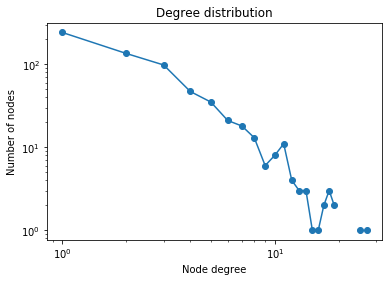

In [46]:
G = nx.Graph()

for index, row in w_edges.iterrows():
    G.add_edge(row['grid1'], row['grid2'], weight=row['count'])

def plotDegreeDistr(graph):
    dh = nx.degree_histogram(graph)
    plt.loglog(dh, '-', marker='o')
    plt.title("Degree distribution")
    plt.ylabel("Number of nodes")
    plt.xlabel("Node degree")

print(nx.info(G))
plotDegreeDistr(G)

In [47]:
centrality = pd.DataFrame.from_dict(nx.algorithms.degree_centrality(G), orient='index', columns=['centrality']).reset_index()
centrality.columns = ['grid', 'centrality']
centrality.head()

,grid,centrality
0,grid.4563.4,0.027523
1,grid.5491.9,0.004587
2,grid.10837.3d,0.041284
3,grid.17272.31,0.003058
4,grid.15822.3c,0.009174


In [48]:
centrality = pd.merge(left=w_nodes, right=centrality, left_on='grid', right_on='grid')
centrality.sort_values('centrality', ascending=False).head(n=10)

,grid,country,continent,centrality
19,grid.10837.3d,GB,EU,0.041284
82,grid.147455.6,US,NA,0.038226
105,grid.168010.e,US,NA,0.029052
101,grid.169077.e,US,NA,0.029052
67,grid.482139.5,FR,EU,0.027523
0,grid.4563.4,GB,EU,0.027523
57,grid.466739.9,PT,EU,0.027523
103,grid.4305.2,GB,EU,0.025994
115,grid.213917.f,US,NA,0.025994
208,grid.5685.e,GB,EU,0.024465


In [49]:
box_data = centrality.groupby('country').agg({'centrality': lambda x: list(x)})

data = [go.Box(
            y=row['centrality'],
            name = index,
            boxmean=True
        ) for index, row in box_data.iterrows()]

layout = go.Layout(showlegend=False)

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/ijhcs_collaborations_centrality.png')

In [50]:
continental_collab = w_edges[(w_edges.continent1 ==  w_edges.continent2) & (w_edges.country1 !=  w_edges.country2)].groupby(['country1', 'country2', 'continent1', 'continent2', 'lat1', 'lon1', 'lat2', 'lon2']).agg({'count':'sum'}).reset_index()
# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler((.1,3))

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(continental_collab[['count']].values.astype(float))

# Run the normalizer on the dataframe
continental_collab['magnitude'] = x_scaled
continental_collab.head()

,country1,country2,continent1,continent2,lat1,lon1,lat2,lon2,count,magnitude
0,AT,DE,EU,EU,47.585494,14.126476,51.106982,10.385781,2,0.261111
1,AT,DK,EU,EU,47.585494,14.126476,55.981253,10.028010,1,0.100000
2,AT,GB,EU,EU,47.585494,14.126476,54.123872,-2.865632,3,0.422222
3,AU,NZ,OC,OC,-25.732887,134.491000,-41.811136,171.484923,1,0.100000
4,BE,GB,EU,EU,50.639816,4.640651,54.123872,-2.865632,2,0.261111


In [51]:
color_key = {
    'EU': 'blue',
    'AS': 'goldenrod',
    'NA': 'crimson',
    'AF': 'magenta',
    'SA': 'lime',
    'OC': 'cyan'
}

continental_routes = []

groups = set()
for index, row in continental_collab.iterrows():
    if row['country1'] != row['country2']:
        continental_routes.append(dict(
            type = 'scattergeo',
            legendgroup = row['continent1'],
            showlegend = False if row['continent1'] in groups else True,
            name=row['continent1'],
            lat = [ row['lat1'], row['lat2'] ],
            lon = [ row['lon1'], row['lon2'] ],
            mode = 'lines',
            line = dict(
                width = row['magnitude'],
                color = color_key[row['continent1']],
            )))
        groups.add(row['continent1'])
        
map_layout = dict(
    title = 'Continental collaborations',
    showlegend = True,         
    geo = dict(
        showframe = False,
        showcoastlines = True,
        projection = dict(
            type = 'equirectangular'
        )
    )
)

fig = go.Figure(data=continental_routes, layout=map_layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/ijhcs_continental_collaborations.png')

In [52]:
intercontinental_collab = w_edges[w_edges.continent1 !=  w_edges.continent2].groupby(['country1', 'country2', 'continent1', 'continent2', 'lat1', 'lon1', 'lat2', 'lon2']).agg({'count':'sum'}).reset_index()
# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler((.1,3))

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(intercontinental_collab[['count']].values.astype(float))

# Run the normalizer on the dataframe
intercontinental_collab['magnitude'] = x_scaled
intercontinental_collab.head()

,country1,country2,continent1,continent2,lat1,lon1,lat2,lon2,count,magnitude
0,AT,US,EU,NA,47.585494,14.126476,45.679547,-112.461674,1,0.100000
1,AU,CA,OC,NA,-25.732887,134.491000,61.362063,-98.307770,2,0.252632
2,AU,ES,OC,EU,-25.732887,134.491000,40.244487,-3.647550,1,0.100000
3,AU,FI,OC,EU,-25.732887,134.491000,64.498846,26.274666,3,0.405263
4,AU,GB,OC,EU,-25.732887,134.491000,54.123872,-2.865632,7,1.015789


In [53]:
def resolve_color(c1, c2):
    cc = [c1, c2]
    if 'EU' in cc and 'NA' in cc:
        return 'orange'
    if 'EU' in cc and 'AS' in cc:
        return 'cyan'
    if 'EU' in cc and 'SA' in cc:
        return 'yellow'
    if 'EU' in cc and 'OC' in cc:
        return 'darkorchid'
    if 'EU' in cc and 'AF' in cc:
        return 'lime'
    if 'NA' in cc and 'AS' in cc:
        return 'crimson'
    if 'NA' in cc and 'SA' in cc:
        return 'lightblue'
    if 'NA' in cc and 'OC' in cc:
        return 'blue'
    if 'NA' in cc and 'AF' in cc:
        return 'goldenrod'
    if 'AS' in cc and 'OC' in cc:
        return 'magenta'
    if 'AS' in cc and 'AF' in cc:
        return 'gold'
    if 'AS' in cc and 'SA' in cc:
        return 'coral'
    if 'AF' in cc and 'SA' in cc:
        return 'royalblue'
    if 'AF' in cc and 'OC' in cc:
        return 'hotpink'
    if 'OC' in cc and 'SA' in cc:
        return 'seagreen'
    else:
        print('unhandled ', cc)

routes = []
groups = set()
for index, row in intercontinental_collab.iterrows():
    group_name = '-'.join(sorted([row['continent1'], row['continent2']]))
    routes.append(dict(
        type = 'scattergeo',
        name=group_name,
        legendgroup=group_name,
        showlegend = False if group_name in groups else True,
        lat = [ row['lat1'], row['lat2'] ],
        lon = [ row['lon1'], row['lon2'] ],
        mode = 'lines',
        line = dict(
            width = row['magnitude'],
            color = resolve_color(row['continent1'], row['continent2']),
        )))
    groups.add(group_name)
        
map_layout = dict(
    title = 'Intercontinental collaborations',
    showlegend = True,         
    geo = dict(
        showframe = False,
        showcoastlines = True,
        projection = dict(
            type = 'equirectangular'
        )
    )
)

fig = go.Figure(data=routes, layout=map_layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/ijhcs_intercontinental_collaborations.png')

## Self-sustaining countries

In [54]:
loners = paper_stats[paper_stats.n_countries == 1].reset_index()
loners['lone_country'] = loners.country.map(lambda x: list(x)[0])

THRESHOLD = 5
loners_data = loners[['lone_country', 'paperid']]\
                .groupby('lone_country')\
                .count()\
                .sort_values(by='paperid', ascending=False).reset_index()
loners_data = loners_data[loners_data.paperid > THRESHOLD]

loners_map = [ dict(
        type = 'choropleth',
        locationmode = 'country names',
        locations = loners_data['lone_country'],
        z = loners_data['paperid'],
        text = loners_data['paperid'],
        autocolorscale = True,
        reversescale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            title = '# papers'),
      ) ]

layout = dict(
    title = 'Self-sustaining countries [with more than %s papers]' % THRESHOLD,
    geo = dict(
        showframe = False,
        showcoastlines = True,
        projection = dict(
            type = 'equirectangular'
        )
    )
)

fig = go.Figure(data=loners_map, layout=layout)
plotly.offline.iplot(fig, validate=False)
pio.write_image(fig, 'reports/images/ijhcs_loners.png')

## Knowledge debit

In [55]:
debt = pd.merge(left=ref_data, right=cite_data, left_on='country', right_on='country',
                suffixes=('_ref','_cite'), how='outer')
debt = pd.merge(left=debt, right=ijhcs_data, left_on='country', right_on='country',
                suffixes=('_ref','_cite'), how='outer')

debt = debt.fillna(0)
debt['debt'] = debt['paperid_cite'] / debt['paperid_ref']

debt.head()

,country,paperid_ref,paperid_cite,paperid,debt
0,Albania,1.0,4.0,0.0,4.000000
1,Antigua and Barbuda,2.0,1.0,0.0,0.500000
2,Argentina,23.0,93.0,5.0,4.043478
3,Australia,1079.0,3650.0,92.0,3.382762
4,Austria,281.0,856.0,15.0,3.046263


In [56]:
debt_map = [dict(type='choropleth',
                 locationmode='country names',
                 locations=debt['country'],
                 z=debt['debt'],
                 text=debt['debt'],
                 autocolorscale=True,
                 reversescale=False,
                 marker = dict(line=dict(color='rgb(180,180,180)',
                                         width = 0.5
                                        )
                              ),
                 colorbar=dict(title='Knowledge debit'))]

layout = dict(title='Knowledge debit',
              geo = dict(showframe=False,
                         showcoastlines=True,
                         projection=dict(type='equirectangular')
                        )
             )

fig = go.Figure(data=debt_map, layout=layout)
plotly.offline.iplot(fig, validate=False)
pio.write_image(fig, 'reports/images/ijhcs_knowledge_debit.png')

## Country ranking similarity

In [57]:
year_country_dois = ijhcs_contributions.groupby(['country', 'year'])[['paperid']].nunique()
year_country_dois = year_country_dois.reset_index().pivot(index='country', columns='year', values='paperid')
year_country_dois = year_country_dois.fillna(0).transpose()
year_country_dois.head()

country,Argentina,Australia,Austria,Belgium,Brazil,Canada,Chile,China,Colombia,Croatia,Cyprus,Czechia,Denmark,Finland,France,Germany,Greece,Hungary,Iceland,India,Iran,Ireland,Israel,Italy,Japan,Kenya,Kuwait,Latvia,Lebanon,Macao,Malaysia,Malta,Mexico,Namibia,Netherlands,New Zealand,Norway,Philippines,Poland,Portugal,Qatar,Russia,Saudi Arabia,Serbia,Singapore,Slovakia,Slovenia,South Africa,South Korea,Spain,Sweden,Switzerland,Taiwan,Thailand,Turkey,United Kingdom,United States
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1969,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,1.0
1970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0
1971,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,7.0
1972,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,6.0
1973,0.0,0.0,0.0,1.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,8.0


In [58]:
spearman_coeffs = pd.DataFrame(columns=['correlation', 'pvalue'])
previous = []
for year, row in year_country_dois.iterrows():
    if len(previous) == 0: # first iteration
        previous = row
    else:
        coeff = spearmanr(previous, row)
        spearman_coeffs.loc[year] = [coeff[0], coeff[1]]
        previous = row
spearman_coeffs

,correlation,pvalue
1970,0.565539,4.563308e-06
1971,0.582605,1.988074e-06
1972,0.582227,2.026056e-06
1973,0.872678,9.206935e-19
1974,0.564639,4.761568e-06
1975,0.666712,1.497908e-08
1976,0.347754,8.034712e-03
1977,0.808322,2.911241e-14
1978,0.601300,7.566275e-07
1979,0.443991,5.410600e-04


In [59]:
trace = go.Scatter(x=spearman_coeffs.index,
                    y=spearman_coeffs['correlation'],
                    name='Spearman similarity')

layout = go.Layout(title='Spearman similarity of country rankings',
                   legend=dict(orientation='h'),
                   yaxis=dict(range=[0, 1]))

fig = go.Figure(data=[trace], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/ijhcs_spearman.png')

## First/Last author analysis

In [60]:
ijhcs_contributions.head()

,paperid,year,order,authorid,name,gridid,affiliation,country,countrycode
824,19554764,2013,1,2106913481,enrico motta,grid.10837.3d,The Open University,United Kingdom,GB
3065,21239000,1974,1,2703520782,i j blain,NaN,NaN,NaN,NaN
2388,22089359,1977,1,2617385127,patrick j hayes,NaN,NaN,NaN,NaN
2628,23658394,1988,1,2423938681,m m taylor,NaN,NaN,NaN,NaN
6907,29221325,1994,1,2695880810,e hollnagel,NaN,NaN,NaN,NaN


In [61]:
ijhcs_first = ijhcs_contributions[ijhcs_contributions.order == 1]
ijhcs_last_authors_idx = ijhcs_contributions.groupby('paperid')['order'].transform(max) == ijhcs_contributions['order']
ijhcs_last = ijhcs_contributions[ijhcs_last_authors_idx]
ijhcs_middle = ijhcs_contributions[ijhcs_last_authors_idx.map(lambda x: not x)]
ijhcs_middle = ijhcs_middle[ijhcs_middle.order != 1]

In [62]:
ijhcs_last_authors = ijhcs_last[['name', 'paperid']]\
                    .groupby(['name']) \
                    .count().sort_values(by=['paperid'], ascending=False)\
                    .reset_index()
ijhcs_last_authors.head(n=10)

,name,paperid
0,ronald r yager,22
1,brian r gaines,18
2,nigel shadbolt,13
3,ian h witten,13
4,gavriel salvendy,12
5,ben shneiderman,12
6,mildred l g shaw,12
7,susan wiedenbeck,11
8,michael d harrison,10
9,mark a musen,9


In [63]:
first_aff = ijhcs_first.groupby(['year']).agg({'gridid':lambda x: set(x)})
first_aff.columns = ['first_gridId']
first_aff.head()

middle_aff = ijhcs_middle.groupby(['year']).agg({'gridid':lambda x: set(x)})
middle_aff.columns = ['middle_gridId']
middle_aff.head()

last_aff = ijhcs_last.groupby(['year']).agg({'gridid':lambda x: set(x)})
last_aff.columns = ['last_gridId']
last_aff.head()

ijhcs_aff = pd.concat([first_aff, middle_aff, last_aff], axis=1)
ijhcs_aff['n_gridIds'] = ijhcs_aff.apply(lambda row: len_of_set_with_nan(row['first_gridId'] | row['last_gridId'] | row['middle_gridId']), axis=1)
ijhcs_aff['n_first_last'] = ijhcs_aff.apply(lambda row: len_of_set_with_nan(row['first_gridId'] | row['last_gridId']), axis=1)
ijhcs_aff['excluded'] = ijhcs_aff.apply(lambda row: row['middle_gridId'] - (row['first_gridId'] | row['last_gridId']), axis=1)
ijhcs_aff['n_excluded'] = ijhcs_aff['excluded'].map(len_of_set_with_nan)
ijhcs_aff['pct_excluded'] = ijhcs_aff['n_excluded'] / ijhcs_aff['n_gridIds']
ijhcs_aff.head(n=5)

,first_gridId,middle_gridId,last_gridId,n_gridIds,n_first_last,excluded,n_excluded,pct_excluded
year,,,,,,,,
1969,"{nan, grid.8356.8, grid.9918.9, grid.426108.9, grid.17063.33, grid.9909.9, grid.410351.2, grid.292516.b, grid.5335.0, grid.22072.35, grid.4464.2, grid.21006.35, grid.17088.36}",{grid.116068.8},"{nan, grid.8356.8, grid.9918.9, grid.426108.9, grid.17063.33, grid.4464.2, grid.116068.8, grid.9909.9, grid.410351.2, grid.292516.b, grid.5335.0, grid.22072.35, grid.9481.4, grid.21006.35}",14,14,{},0,0.0
1970,"{nan, grid.8356.8, grid.9759.2, grid.4800.c, grid.98913.3a, grid.465651.5, grid.14003.36, grid.9757.c}",{grid.4800.c},"{nan, grid.8356.8, grid.9759.2, grid.4800.c, grid.98913.3a, grid.465651.5, grid.14003.36, grid.9757.c}",7,7,{},0,0.0
1971,"{nan, grid.266842.c, grid.253564.3, grid.9759.2, grid.15276.37, grid.10837.3d, grid.5018.c, grid.47894.36, grid.4305.2, grid.27860.3b, grid.21925.3d, grid.1016.6, grid.451487.b, grid.9757.c}","{grid.15276.37, grid.27860.3b}","{nan, grid.266842.c, grid.253564.3, grid.9759.2, grid.10837.3d, grid.5018.c, grid.47894.36, grid.4305.2, grid.21925.3d, grid.476836.8, grid.1016.6, grid.451487.b, grid.9757.c}",14,14,{},0,0.0
1972,"{nan, grid.8356.8, grid.266683.f, grid.47894.36, grid.223827.e, grid.9909.9, grid.9435.b, grid.264091.8, grid.22072.35, grid.4464.2, grid.17091.3e, grid.9757.c, grid.257410.5}",{grid.9909.9},"{nan, grid.8356.8, grid.266683.f, grid.47894.36, grid.223827.e, grid.9909.9, grid.9435.b, grid.264091.8, grid.22072.35, grid.4464.2, grid.17091.3e, grid.9757.c, grid.257410.5}",12,12,{},0,0.0
1973,"{nan, grid.273335.3, grid.8356.8, grid.9759.2, grid.183158.6, grid.7942.8, grid.214458.e, grid.266683.f, grid.9909.9, grid.22072.35, grid.61971.38, grid.267455.7, grid.211367.0, grid.451487.b, grid.25152.31, grid.17089.37}","{nan, grid.451487.b}","{nan, grid.273335.3, grid.8356.8, grid.9759.2, grid.183158.6, grid.7942.8, grid.214458.e, grid.266683.f, grid.9909.9, grid.22072.35, grid.61971.38, grid.267455.7, grid.211367.0, grid.451487.b, grid.25152.31, grid.17089.37}",15,15,{},0,0.0


In [64]:
trace1 = go.Scatter(x=ijhcs_aff.index,
                    y=ijhcs_aff['n_gridIds'],
                    name='total gridIDs',
                    marker=dict(symbol='circle'),
                    mode='lines+markers')

trace2 = go.Scatter(x=ijhcs_aff.index,
                    y=ijhcs_aff['n_first_last'],
                    name='gridIDs (first & last authors)',
                    marker=dict(symbol='cross'),
                    mode='lines+markers')
                    
trace3 = go.Scatter(x=ijhcs_aff.index,
                    y=ijhcs_aff['n_excluded'],
                    name='gridIDs (middle authors)',
                    marker=dict(symbol='triangle-up'),
                    mode='lines+markers')

layout = go.Layout(title="gridIds breakdown by author position",
                   legend=dict(orientation='h'))

fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/ijhcs_authors_gridids.png')

In [65]:
trace1 = go.Scatter(x=ijhcs_aff.index,
                    y=ijhcs_aff.pct_excluded,
                    marker=dict(symbol='circle'),
                    mode='lines+markers')

layout = go.Layout(title="Percentage of institutions not presenting papers as first/last author's affiliation",
                   legend=dict(orientation='h'),
                   yaxis=dict(range=[-.018, 1]))

fig = go.Figure(data=[trace1], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/ijhcs_excluded_gridids.png')

In [66]:
first_countries = ijhcs_first.groupby(['year']).agg({'country':lambda x: set(x)})
first_countries.columns = ['first_countrycode']
first_countries.head()

middle_countries = ijhcs_middle.groupby(['year']).agg({'country':lambda x: set(x)})
middle_countries.columns = ['middle_countrycode']
middle_countries.head()

last_countries = ijhcs_last.groupby(['year']).agg({'country':lambda x: set(x)})
last_countries.columns = ['last_countrycode']
last_countries.head()

ijhcs_countries = pd.concat([first_countries, middle_countries, last_countries], axis=1)
ijhcs_countries['n_countrycodes'] = ijhcs_countries.apply(lambda row: len_of_set_with_nan(row['first_countrycode'] | row['last_countrycode'] | row['middle_countrycode']), axis=1)
ijhcs_countries['n_first_last'] = ijhcs_countries.apply(lambda row: len_of_set_with_nan(row['first_countrycode'] | row['last_countrycode']), axis=1)
ijhcs_countries['excluded'] = ijhcs_countries.apply(lambda row: row['middle_countrycode'] - (row['first_countrycode'] | row['last_countrycode']), axis=1)
ijhcs_countries['n_excluded'] = ijhcs_countries['excluded'].map(len_of_set_with_nan)
ijhcs_countries['pct_excluded'] = ijhcs_countries['n_excluded'] / ijhcs_countries['n_countrycodes']
ijhcs_countries.head(n=5)

,first_countrycode,middle_countrycode,last_countrycode,n_countrycodes,n_first_last,excluded,n_excluded,pct_excluded
year,,,,,,,,
1969,"{nan, United States, Canada, New Zealand, United Kingdom}",{United States},"{nan, United States, Canada, New Zealand, United Kingdom}",4,4,{},0,0.0
1970,"{nan, United States, Italy, United Kingdom}",{Italy},"{nan, United States, Italy, United Kingdom}",3,3,{},0,0.0
1971,"{nan, Hungary, United States, Australia, United Kingdom}",{United States},"{nan, Hungary, United States, Australia, United Kingdom}",4,4,{},0,0.0
1972,"{nan, Canada, United States, United Kingdom}",{United Kingdom},"{nan, Canada, United States, United Kingdom}",3,3,{},0,0.0
1973,"{nan, Belgium, United States, Canada, United Kingdom}","{nan, United States}","{nan, Belgium, United States, Canada, United Kingdom}",4,4,{},0,0.0


In [67]:
trace1 = go.Scatter(x=ijhcs_countries.index,
                    y=ijhcs_countries['n_countrycodes'],
                    name='total countries',
                    marker=dict(symbol='circle'),
                    mode='lines+markers')

trace2 = go.Scatter(x=ijhcs_countries.index,
                    y=ijhcs_countries['n_first_last'],
                    name='countries (first & last authors)',
                    marker=dict(symbol='cross'),
                    mode='lines+markers')
                    
trace3 = go.Scatter(x=ijhcs_countries.index,
                    y=ijhcs_countries['n_excluded'],
                    name='countries (middle authors)',
                    marker=dict(symbol='triangle-up'),
                    mode='lines+markers')

layout = go.Layout(title='Countries breakdown by author position',
                   legend=dict(orientation='h'))

fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/ijhcs_authors_countries.png')

In [68]:
trace1 = go.Scatter(x=ijhcs_countries.index,
                    y=ijhcs_countries.pct_excluded,
                    marker=dict(symbol='circle'),
                    mode='lines+markers')

layout = go.Layout(title="Percentage of countries not presenting papers as first/last author's affiliation",
                   legend=dict(orientation='h'),
                   yaxis=dict(range=[-.018, 1]))

fig = go.Figure(data=[trace1], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/ijhcs_excluded_countries.png')